# Load Packages, Load Data, Prepare Target Variable

In [1]:
import plotly.graph_objs as go
import plotly.offline as py
%matplotlib inline
py.init_notebook_mode(connected=True)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
from sklearn.metrics import log_loss, precision_score, recall_score
import statsmodels.api as sm
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

C:\Users\Mohan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
data = pd.read_table('loan_data.txt')
data = data[data['loan_status'].notnull()]
data['loan'] = np.where((data['loan_status']=='Fully Paid') | (data['loan_status']=='Current'), 1, 0)
data =data.drop('loan_status', axis=1)

# Preprocess

### Data Cleaning

In [3]:
data.head()

,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,purpose,...,total_pymnt,total_rec_prncp,total_rec_int,wtd_loans,interest_rate,int_rate2,num_rate,numrate,int_rate3,loan
0,641849,13200,13200,36 months,18.49,480.47,2 years,RENT,110000.0,debt_consolidation,...,4324.23,2653.07,1671.16,NaN,NaN,18.49%,NaN,NaN,18.49,1
1,734736,21600,21600,36 months,7.90,675.87,10+ years,MORTGAGE,95000.0,house,...,23521.69,21600.00,1921.69,NaN,NaN,7.90%,NaN,NaN,7.90,1
2,807342,21000,21000,36 months,6.62,644.78,10+ years,MORTGAGE,121392.0,major_purchase,...,7092.58,5981.40,1111.18,NaN,NaN,6.62%,NaN,NaN,6.62,1
3,880114,5600,5600,36 months,9.99,180.67,1 year,RENT,75000.0,debt_consolidation,...,903.35,681.50,221.85,NaN,NaN,9.99%,NaN,NaN,9.99,1
4,999547,16000,16000,36 months,10.16,517.48,NaN,RENT,155000.0,debt_consolidation,...,5391.45,4000.21,1365.39,NaN,NaN,10.16%,NaN,NaN,10.16,0


In [4]:
data = data.replace('n/a', np.nan)

In [5]:
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
min_time = min(data['earliest_cr_line'])
data['earliest_cr_day'] = (data['earliest_cr_line']-min_time).dt.days
data = data.drop('earliest_cr_line', axis=1)

### Missing Value Checks

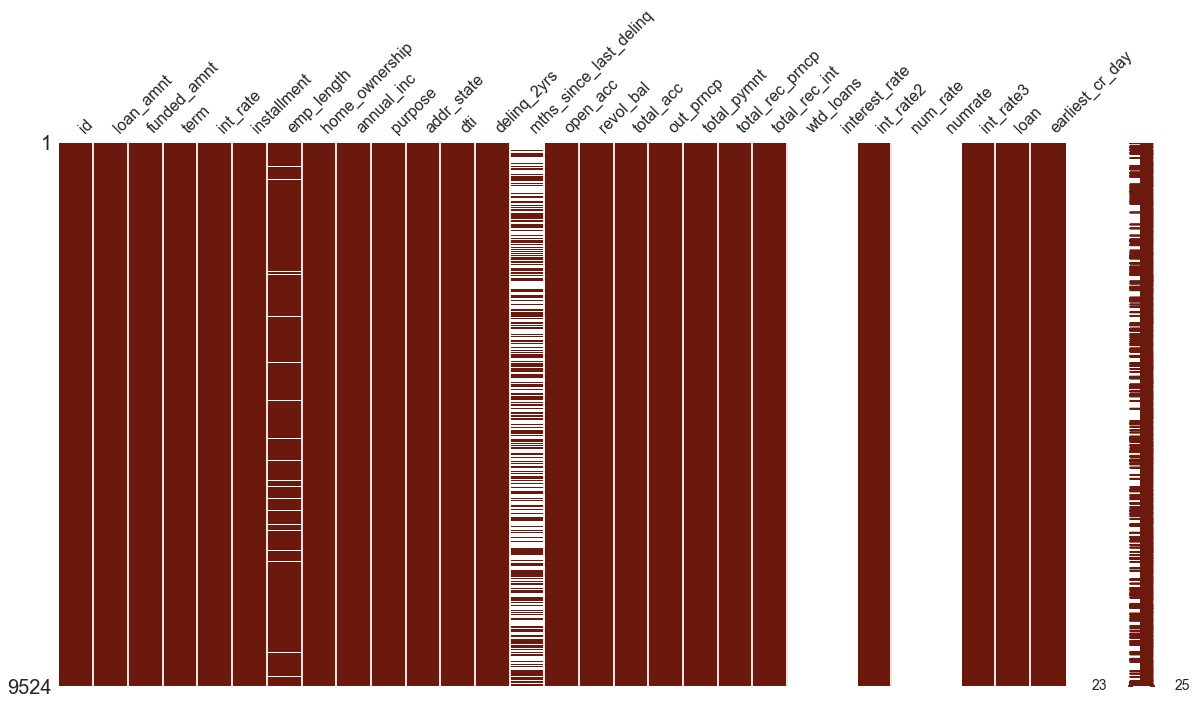

In [6]:
msno.matrix(df=data, figsize=(20, 10), color=(0.42, 0.1, 0.05))

In [7]:
print((sum(data['mths_since_last_delinq'].isnull())/len(data), sum(data['emp_length'].isnull())/len(data)))

(0.5695086098278035, 0.04252414951700966)


In [8]:
print((sum(data[data['emp_length'].isnull()]['loan'])/len(data[data['emp_length'].isnull()]), 
 sum(data['loan'])/len(data['loan'])))

(0.945679012345679, 0.9526459470810584)


In [9]:
data['emp_length']=data['emp_length'].str.strip(' years')
data['emp_length']=data['emp_length'].str.strip('+')
data['emp_length']=data['emp_length'].str.strip('< ')
data['emp_length']=data['emp_length'].astype('float')
data['emp_length']= data['emp_length'].fillna(data['emp_length'].median())

AxesSubplot(0.125,0.125;0.62x0.755)


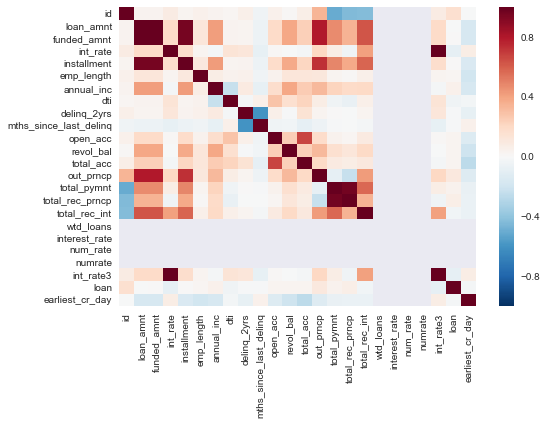

In [10]:
corr = data.corr()
print(sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values))

In [11]:
data = data.drop(['wtd_loans', 'interest_rate', 'num_rate', 'numrate', 'int_rate2',
                  'int_rate3', 'funded_amnt', 'installment', 'total_rec_prncp', 'mths_since_last_delinq'],axis=1)

In [12]:
data = pd.get_dummies(data)

In [13]:
dist = [go.Bar(
            x = data['loan'].value_counts().index.values,
            y = data['loan'].value_counts().values,
            text='Distribution of target variable'
    )]
layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=dist, layout=layout)

py.iplot(fig, filename='basic-bar')

### Split Train/Test

In [14]:
x_train, x_test= train_test_split(data,test_size=0.20, random_state=0)

# Model Analysis

### Random Forest Result

In [15]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=6, max_features=0.7, n_jobs=-1, random_state=0)
rf.fit(x_train.drop('loan',axis=1), x_train['loan'])
features = x_train.columns.values
print("----- Training Done -----")

----- Training Done -----


In [16]:
rf_test = rf.predict_proba(x_test.drop('loan',axis=1))[:,1]
rf_test2 = rf.predict(x_test.drop('loan',axis=1))
recall = recall_score(x_test['loan'], rf_test2)
precision = precision_score(x_test['loan'], rf_test2)
print('recall:{}, precision:{}, log_loss:{}, accurary:{}'.format(recall, precision, log_loss(x_test['loan'], rf_test),
                                                                 rf.score(x_test.drop('loan',axis=1), x_test['loan'])))

recall:1.0, precision:0.9759358288770054, log_loss:0.10911222829859336, accurary:0.9763779527559056


In [17]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace= go.Bar(
    x=x, y=y, 
    orientation='h',
)

layout = dict(
    title='Feature importances',
    width = 1000, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

### Logistic Regression Results

In [18]:
log = sm.GLM(x_train['loan'], x_train.drop('loan',axis=1), family=sm.families.Binomial())
log = log.fit()
print(log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   loan   No. Observations:                 7619
Model:                            GLM   Df Residuals:                     7543
Model Family:                Binomial   Df Model:                           75
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -785.40
Date:                Sun, 04 Feb 2018   Deviance:                       1570.8
Time:                        06:30:28   Pearson chi2:                 1.25e+04
No. Iterations:                    23                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
id                          5.039e-07   5.64e-08      8.938      0.000    3.93e-07    6.14e-07
loan

In [19]:
log2_test = log.predict(x_test.drop('loan',axis=1))
l_test2 = np.array([0]*len(log2_test))
l_test2[log2_test > 0.5] = 1
l_test2[log2_test <= 0.5] = 0
recall = recall_score(x_test['loan'], l_test2)
precision = precision_score(x_test['loan'], l_test2)
print('recall:{}, precision:{}, log_loss:{}, accurary:{}'.format(recall, precision, log_loss(x_test['loan'], log2_test),
                                                                 sum(l_test2==x_test['loan'])/len(l_test2)))

recall:1.0, precision:0.976457998929909, log_loss:0.10251898442281264, accurary:0.9769028871391076


### Variable Selection

In [20]:
x_train = x_train[list(log.params.index[:14])+['loan']]
x_test = x_test[list(log.params.index[:14])+['loan']]

In [21]:
log = sm.GLM(x_train['loan'], x_train.drop('loan',axis=1), family=sm.families.Binomial())
log = log.fit()
print(log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   loan   No. Observations:                 7619
Model:                            GLM   Df Residuals:                     7605
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -834.83
Date:                Sun, 04 Feb 2018   Deviance:                       1669.7
Time:                        06:30:29   Pearson chi2:                 9.08e+04
No. Iterations:                     9                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
id               5.458e-07   5.25e-08     10.387      0.000    4.43e-07    6.49e-07
loan_amnt          -0.0015      0.000

In [22]:
def stepwise(data):
    log = sm.GLM(data['loan'], data.drop('loan',axis=1), family=sm.families.Binomial())
    log = log.fit()
    while log.pvalues.max()>0.05:
        drop = log.params.index[np.where(log.pvalues==log.pvalues.max())][0]
        params = list(log.params.index) + ['loan']
        params.remove(drop)
        data = data[params]
        log = sm.GLM(data['loan'], data.drop('loan',axis=1), family=sm.families.Binomial())
        log = log.fit()
    return params

In [23]:
params = stepwise(x_train)
x_train = x_train[params]
x_test = x_test[params]

In [24]:
log = sm.GLM(x_train['loan'], x_train.drop('loan',axis=1), family=sm.families.Binomial())
log = log.fit()
print(log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   loan   No. Observations:                 7619
Model:                            GLM   Df Residuals:                     7610
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -837.96
Date:                Sun, 04 Feb 2018   Deviance:                       1675.9
Time:                        06:30:29   Pearson chi2:                 1.13e+05
No. Iterations:                     9                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
id               5.529e-07   5.21e-08     10.613      0.000    4.51e-07    6.55e-07
loan_amnt          -0.0015      0.000

In [25]:
log2_test = log.predict(x_test.drop('loan',axis=1))
l_test2 = np.array([0]*len(log2_test))
l_test2[log2_test > 0.5] = 1
l_test2[log2_test <= 0.5] = 0
recall = recall_score(x_test['loan'], l_test2)
precision = precision_score(x_test['loan'], l_test2)
print('recall:{}, precision:{}, log_loss:{}, accurary:{}'.format(recall, precision, log_loss(x_test['loan'], log2_test),
                                                                 sum(l_test2==x_test['loan'])/len(l_test2)))

recall:1.0, precision:0.9769807280513919, log_loss:0.09781878575351201, accurary:0.9774278215223097
